In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error

/home/vt337/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
proj_dir = Path("..") / "Data/r77-mini-data-fortnight"
print(proj_dir.joinpath("input"))

data_dir = proj_dir
input_dir = data_dir.joinpath("input")
fixed_input_dir = input_dir.joinpath("fixed")
temporal_input_dir = input_dir.joinpath("temporal")
target_dir = data_dir.joinpath("target")
fixed_target_dir = target_dir.joinpath("fixed")
temporal_target_dir = target_dir.joinpath("temporal")

../Data/r77-mini-data-fortnight/input


In [3]:
files = list(temporal_target_dir.iterdir())


index_dir = Path("..")/"Index"
files_index = list(index_dir.iterdir())
indices = np.load(files_index[0]).squeeze()

#First hour of data
index = indices[0]
tt = np.load(files[index]).squeeze()
tt.shape

(144, 70, 100, 3)

In [4]:
files_ti = list(temporal_input_dir.iterdir())

In [5]:
#all diff data
data = []

for j in range(360):
    index = indices[j]

    tt = np.load(files[index]).squeeze()
    tt = np.transpose(tt, (0, 2, 3, 1))[:, :, :, :64]  #shape: (144, 100, 3, 64)

    ti = np.load(files_ti[index]).squeeze()
    ti = np.transpose(ti, (0, 2, 1))[:, :, :64]  #shape: (144, 3, 64)

    #ensure ti has the same second dimension as tt
    ti_expanded = np.repeat(ti[:, None, :, :], tt.shape[1], axis=1)  #shape: (144, 100, 3, 64)

    #calculate diff and reshape
    diff_data = tt - ti_expanded  #shape: (144, 100, 3, 64)
    reshaped_tt = diff_data.reshape(-1, 3, 64)  #shape: (14400, 3, 64)

    data.append(reshaped_tt)


data = np.concatenate(data).reshape(-1, 3, 64)
data.shape

(5184000, 3, 64)

In [6]:
def normalise(vector):
    min_val = np.min(vector)
    max_val = np.max(vector)
    normalised_vector = (vector - min_val) / (max_val - min_val)
    return normalised_vector, min_val, max_val

In [13]:
files_fixed = list(fixed_input_dir.iterdir())
files_ft = list(fixed_target_dir.iterdir())
#std dev calculated for each grid using fxed target vectors, combined with fixed input vector to give three fixed variables for each grid
#fixed variables all (fixed input repeated 100 times for each grid)

cond = []

for j in range(360):
    index = indices[j]
    fi = np.load(files_fixed[index]).squeeze()
    ft = np.load(files_ft[index]).squeeze()

    stdev_orog = np.array([np.std(i) for i in ft[:,:,1]]).reshape(-1,1)
    fixed_input = np.hstack((fi, stdev_orog))
    reshaped_fi = np.repeat(fixed_input, 100, axis=0)
    cond.append(reshaped_fi)


cond = np.concatenate(cond).reshape(-1, 3)
cond.shape

(5184000, 3)

In [14]:
lsf = cond[:,0]
orog = cond[:,1]
stdev_orog = cond[:,2]

In [15]:
#all data
tt_all = np.stack([
    np.transpose(np.load(files[indices[i]]).squeeze(), (0, 2, 3, 1))[:,:,:,:64].reshape((14400, 3, 64), order = 'C')
    for i in range(360)
])

all_data = tt_all.reshape(-1,3,64)
all_data.shape

(5184000, 3, 64)

In [10]:
#has inversion
def has_inversion(temperature_profile, troposphere_height):
    gradient = np.gradient(temperature_profile[:troposphere_height])
    return np.any(np.array(gradient) > 0.0)

temp = all_data[:,2,:]

inversion = np.array([has_inversion(i, 40) for i in temp])
inversion[inversion == False].shape[0]

1220648

In [11]:
indices1 = np.where((inversion == False))[0]
data1 = data[indices1]

indices2 = np.where((inversion == True))[0]
data2 = data[indices2]

print(f'no inversion training data {data1.shape}')
print(f'has inversion training data {data2.shape}')

no inversion training data (1220648, 3, 64)
has inversion training data (3963352, 3, 64)


In [12]:
indices1 = np.where((inversion == False) & (lsf <= 0.2))[0]
training_data1 =data[indices1]

indices2 = np.where((inversion == False) & (lsf == 1) & (orog < 0.06))[0]
training_data2 = data[indices2]

indices3 = np.where((inversion == False) & (lsf == 1) & (orog > 0.06))[0]
training_data3 = data[indices3]

indices4 = np.where((inversion == False) & (lsf < 1) & (lsf > 0.2) & (orog < 0.03))[0]
training_data4 = data[indices4]

indices5 = np.where((inversion == False) & (lsf < 1) & (lsf > 0.2) & (orog > 0.03))[0]
training_data5 = data[indices5]

indices6 = np.where((inversion == True) & (lsf <= 0.2))[0]
training_data6 = data[indices6]

indices7 = np.where((inversion == True) & (lsf == 1) & (orog < 0.06))[0]
training_data7 = data[indices7]

indices8 = np.where((inversion == True) & (lsf == 1) & (orog > 0.06))[0]
training_data8 = data[indices8]

indices9 = np.where((inversion == True) & (lsf < 1) & (lsf > 0.2) & (orog < 0.03))[0]
training_data9 = data[indices9]

indices10 = np.where((inversion == True) & (lsf < 1) & (lsf > 0.2) & (orog > 0.03))[0]
training_data10 = data[indices10]

In [13]:
num_steps = {
    10000: 'Samples_cond_diffs_1',
    100000: 'Samples_cond_diffs_A'
}

j = 100000


sample_diff_dir = Path(num_steps[j])
files_sample_diff = list(sample_diff_dir.iterdir())

sample_diffs = np.load(files_sample_diff[0]).squeeze()
sample_diffs.shape

(10, 10000, 3, 64)

In [14]:
def denormalise(normalised_vector, min_val, max_val):
    original_vector = normalised_vector * (max_val - min_val) + min_val
    return original_vector

#samples = denormalise(sample_diffs, min_val, max_val)

In [15]:
classes = {
    1: 'Class 1 (No Inversion & Sea)',
    2: 'Class 2 (No Inversion & Land & Orography < 240m)',
    3: 'Class 3 (No Inversion & Land & Orography > 240m)',
    4: 'Class 4 (No Inversion & Coastal & Orography < 120m)',
    5: 'Class 5 (No Inversion & Coastal & Orography > 120m)',
    6: 'Class 6 (Inversion & Sea)',
    7: 'Class 7 (Inversion & Land & Orography < 240m)',
    8: 'Class 8 (Inversion & Land & Orography > 240m)',
    9: 'Class 9 (Inversion & Coastal & Orography < 120m)',
    10: 'Class 10 (Inversion & Coastal & Orography > 120m)'
}

data_list = [training_data1, training_data2, training_data3,training_data4,training_data5,training_data6, training_data7, training_data8,training_data9,training_data10 ]


In [16]:
#class
i = 9

min_val = normalise(data_list[i])[1]
max_val = normalise(data_list[i])[2]
sample = denormalise(sample_diffs[i,:,:,:], min_val, max_val)

sample_humidity = sample[:, 0, :]*0.025
sample_pressure = sample[:, 1, :]*106000
sample_temperature = sample[:, 2, :]*180

target_humidity = data_list[i][:,0,:]*0.025
target_pressure = data_list[i][:,1,:]*106000
target_temperature = data_list[i][:,2,:]*180

#humid
target_mean_1h = np.mean(target_humidity, axis= 0)
sample_mean_1h = np.mean(sample_humidity, axis=0)
target_variance_1h= np.var(target_humidity, axis= 0)
sample_variance_1h = np.var(sample_humidity, axis=0)

#press
target_mean_1p = np.mean(target_pressure, axis= 0)
sample_mean_1p = np.mean(sample_pressure, axis=0)
target_variance_1p= np.var(target_pressure, axis= 0)
sample_variance_1p = np.var(sample_pressure, axis=0)

#temp
target_mean_1t = np.mean(target_temperature, axis= 0)
sample_mean_1t = np.mean(sample_temperature, axis=0)
target_variance_1t= np.var(target_temperature, axis= 0)
sample_variance_1t = np.var(sample_temperature, axis=0)

mse_hum = mean_squared_error(target_mean_1h, sample_mean_1h)
mse_pres = mean_squared_error(target_mean_1p, sample_mean_1p)
mse_temp = mean_squared_error(target_mean_1t, sample_mean_1t)

mse_hum_v = mean_squared_error(np.sqrt(target_variance_1h), np.sqrt(sample_variance_1h))
mse_pres_v = mean_squared_error(np.sqrt(target_variance_1p), np.sqrt(sample_variance_1p))
mse_temp_v = mean_squared_error(np.sqrt(target_variance_1t), np.sqrt(sample_variance_1t))

print(f'Mean squared error between means: {mse_hum} kg/kg')
print(f'Mean squared error between variances: {mse_hum_v} kg/kg')
print(f'Mean squared error between means: {mse_pres} Pa')
print(f'Mean squared error between variances: {mse_pres_v} Pa')
print(f'Mean squared error between means: {mse_temp}(\u00B0C)')
print(f'Mean squared error between variances: {mse_temp_v}(\u00B0C)')



Mean squared error between means: 6.173614397475546e-11 kg/kg
Mean squared error between variances: 4.086064375741216e-09 kg/kg
Mean squared error between means: 54675.4375 Pa
Mean squared error between variances: 1842.856201171875 Pa
Mean squared error between means: 0.021403566002845764(°C)
Mean squared error between variances: 0.0911271870136261(°C)


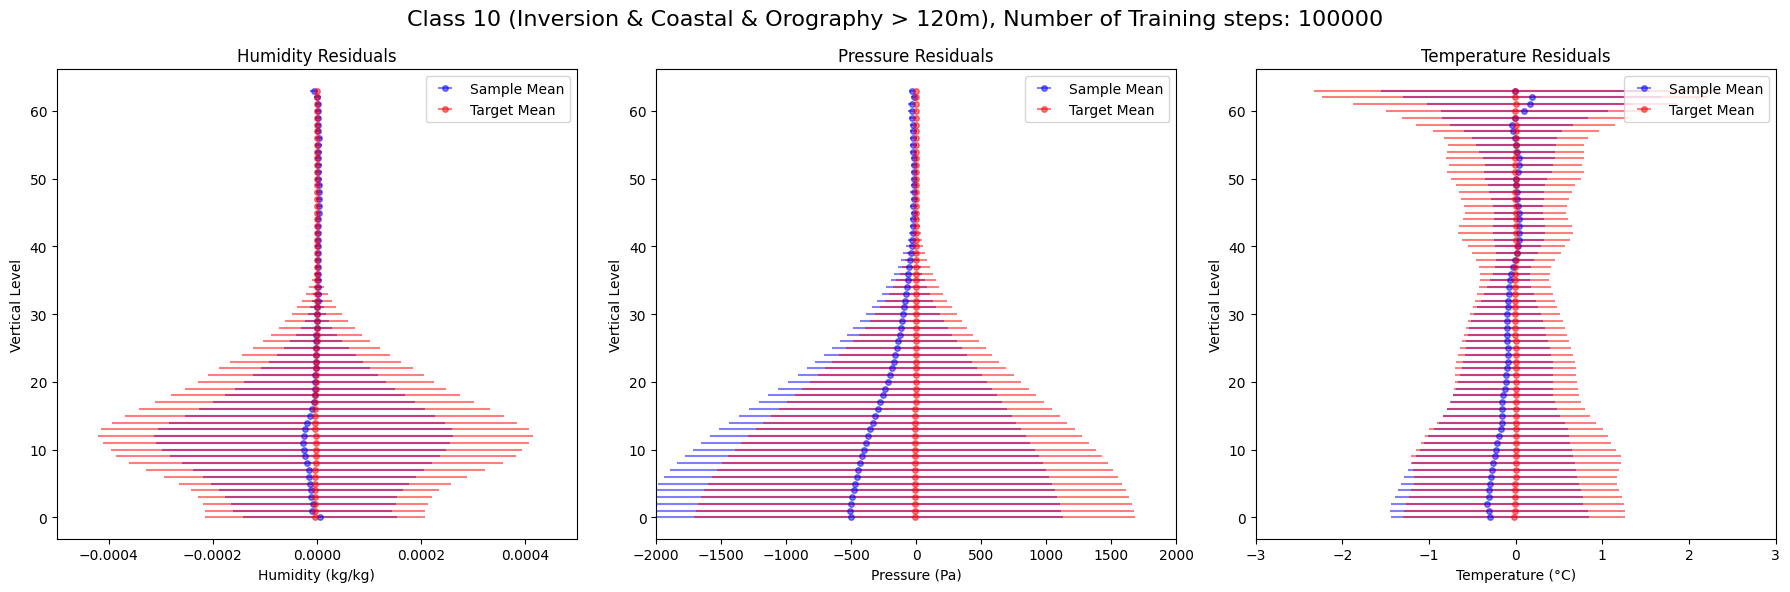

In [17]:


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].errorbar(sample_mean_1h, np.arange(64), xerr=np.sqrt(sample_variance_1h), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[0].errorbar(target_mean_1h, np.arange(64), xerr=np.sqrt(target_variance_1h), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[0].set_title('Humidity Residuals')
axs[0].set_xlabel('Humidity (kg/kg)')
axs[0].set_ylabel('Vertical Level')
axs[0].set_xlim(-0.0005, 0.0005)
axs[0].legend()

axs[1].errorbar(sample_mean_1p, np.arange(64), xerr=np.sqrt(sample_variance_1p), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[1].errorbar(target_mean_1p, np.arange(64), xerr=np.sqrt(target_variance_1p), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[1].set_title('Pressure Residuals')
axs[1].set_xlabel('Pressure (Pa)')
axs[1].set_ylabel('Vertical Level')
axs[1].set_xlim(-2000, 2000)
axs[1].legend()


axs[2].errorbar(sample_mean_1t, np.arange(64), xerr=np.sqrt(sample_variance_1t), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[2].errorbar(target_mean_1t, np.arange(64), xerr=np.sqrt(target_variance_1t), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[2].set_title('Temperature Residuals')
axs[2].set_xlabel('Temperature (\u00B0C)')
axs[2].set_ylabel('Vertical Level')
axs[2].set_xlim(-3, 3)
axs[2].legend()

fig.suptitle(f'{classes[i+1]}, Number of Training steps: {j}', fontsize = 16)
plt.tight_layout()


plt.show()




In [18]:
mse_hum = mean_squared_error(target_mean_1h, sample_mean_1h)
mse_pres = mean_squared_error(target_mean_1p, sample_mean_1p)
mse_temp = mean_squared_error(target_mean_1t, sample_mean_1t)

mse_hum_v = mean_squared_error(np.sqrt(target_variance_1h), np.sqrt(sample_variance_1h))
mse_pres_v = mean_squared_error(np.sqrt(target_variance_1p), np.sqrt(sample_variance_1p))
mse_temp_v = mean_squared_error(np.sqrt(target_variance_1t), np.sqrt(sample_variance_1t))

print(f'Mean squared error between means: {mse_hum} kg/kg')
print(f'Mean squared error between variances: {mse_hum_v} kg/kg')
print(f'Mean squared error between means: {mse_pres} Pa')
print(f'Mean squared error between variances: {mse_pres_v} Pa')
print(f'Mean squared error between means: {mse_temp}(\u00B0C)')
print(f'Mean squared error between variances: {mse_temp_v}(\u00B0C)')

Mean squared error between means: 6.173614397475546e-11 kg/kg
Mean squared error between variances: 4.086064375741216e-09 kg/kg
Mean squared error between means: 54675.4375 Pa
Mean squared error between variances: 1842.856201171875 Pa
Mean squared error between means: 0.021403566002845764(°C)
Mean squared error between variances: 0.0911271870136261(°C)


In [16]:
indices1 = np.where((inversion == False) & (lsf <= 0.2))[0]
trainingdata1 = data[indices1]

indices2 = np.where((inversion == False) & (lsf == 1) & (stdev_orog < 0.025))[0]
trainingdata2 = data[indices2]

indices3 = np.where((inversion == False) & (lsf == 1) & (stdev_orog > 0.025))[0]
trainingdata3 = data[indices3]

indices4 = np.where((inversion == False) & (lsf < 1) & (lsf > 0.2) & (stdev_orog < 0.03))[0]
trainingdata4 = data[indices4]

indices5 = np.where((inversion == False) & (lsf < 1) & (lsf > 0.2) & (stdev_orog > 0.03))[0]
trainingdata5 = data[indices5]

indices6 = np.where((inversion == True) & (lsf <= 0.2))[0]
trainingdata6 = data[indices6]

indices7 = np.where((inversion == True) & (lsf == 1) & (stdev_orog < 0.025))[0]
trainingdata7 = data[indices7]

indices8 = np.where((inversion == True) & (lsf == 1) & (stdev_orog > 0.025))[0]
trainingdata8 = data[indices8]

indices9 = np.where((inversion == True) & (lsf < 1) & (lsf > 0.2) & (stdev_orog < 0.03))[0]
trainingdata9 = data[indices9]

indices10 = np.where((inversion == True) & (lsf < 1) & (lsf > 0.2) & (stdev_orog > 0.03))[0]
trainingdata10 = data[indices10]

In [17]:
print(f'class1 training data {trainingdata1.shape}, {round(trainingdata1.shape[0]/5184000, 3)*100}')
print(f'class2 training data {trainingdata2.shape},{round(trainingdata2.shape[0]/5184000, 3)*100}')
print(f'class3 training data {trainingdata3.shape}, {round(trainingdata3.shape[0]/5184000, 3)*100}')
print(f'class4 training data {trainingdata4.shape}, {round(trainingdata4.shape[0]/5184000, 3)*100}')
print(f'class5 training data {trainingdata5.shape}, {round(trainingdata5.shape[0]/5184000, 3)*100}')
print(f'class6 training data {trainingdata6.shape}, {round(trainingdata6.shape[0]/5184000, 3)*100}')
print(f'class7 training data {trainingdata7.shape}, {round(trainingdata7.shape[0]/5184000, 3)*100}')
print(f'class8 training data {trainingdata8.shape}, {round(trainingdata8.shape[0]/5184000, 3)*100}')
print(f'class9 training data {trainingdata9.shape}, {round(trainingdata9.shape[0]/5184000, 3)*100}')
print(f'class10 training data {trainingdata10.shape}, {round(trainingdata10.shape[0]/5184000, 3)*100}')

class1 training data (645213, 3, 64), 12.4
class2 training data (96400, 3, 64),1.9
class3 training data (77830, 3, 64), 1.5
class4 training data (278033, 3, 64), 5.4
class5 training data (123172, 3, 64), 2.4
class6 training data (2018787, 3, 64), 38.9
class7 training data (360200, 3, 64), 6.9
class8 training data (257570, 3, 64), 5.0
class9 training data (928967, 3, 64), 17.9
class10 training data (397828, 3, 64), 7.7


In [18]:
num_steps = {
    10000: 'Samples_cond_diffs_C',
    100000: 'Samples_cond_diffs_B'
}

j = 10000


sample_diff_dir = Path(num_steps[j])
files_sample_diff = list(sample_diff_dir.iterdir())

sample_diffs = np.load(files_sample_diff[0]).squeeze()
sample_diffs.shape

(10, 10000, 3, 64)

In [19]:
def denormalise(normalised_vector, min_val, max_val):
    original_vector = normalised_vector * (max_val - min_val) + min_val
    return original_vector



In [20]:
classes = {
    1: 'Class 1 (No Inversion & Sea)',
    2: 'Class 2 (No Inversion & Land & Standard Deviation of Orography < 100m)',
    3: 'Class 3 (No Inversion & Land & Standard Deviation of Orography > 100m)',
    4: 'Class 4 (No Inversion & Coastal & Standard Deviation of Orography < 120m)',
    5: 'Class 5 (No Inversion & Coastal & Standard Deviation of Orography > 120m)',
    6: 'Class 6 (Inversion & Sea)',
    7: 'Class 7 (Inversion & Land & Standard Deviation of Orography < 100m)',
    8: 'Class 8 (Inversion & Land & Standard Deviation of Orography > 100m)',
    9: 'Class 9 (Inversion & Coastal & Standard Deviation of Orography < 120m)',
    10: 'Class 10 (Inversion & Coastal & Standard Deviation of Orography > 120m)'
}

data_list = [trainingdata1, trainingdata2, trainingdata3,trainingdata4,trainingdata5,trainingdata6, trainingdata7, trainingdata8,trainingdata9,trainingdata10 ]

In [41]:
#class
i = 9

min_val = normalise(data_list[i])[1]
max_val = normalise(data_list[i])[2]
sample = denormalise(sample_diffs[i,:,:,:], min_val, max_val)

sample_humidity = sample[:, 0, :]*0.025
sample_pressure = sample[:, 1, :]*106000
sample_temperature = sample[:, 2, :]*180

target_humidity = data_list[i][:,0,:]*0.025
target_pressure = data_list[i][:,1,:]*106000
target_temperature = data_list[i][:,2,:]*180

#humid
target_mean_1h = np.mean(target_humidity, axis= 0)
sample_mean_1h = np.mean(sample_humidity, axis=0)
target_variance_1h= np.var(target_humidity, axis= 0)
sample_variance_1h = np.var(sample_humidity, axis=0)

#press
target_mean_1p = np.mean(target_pressure, axis= 0)
sample_mean_1p = np.mean(sample_pressure, axis=0)
target_variance_1p= np.var(target_pressure, axis= 0)
sample_variance_1p = np.var(sample_pressure, axis=0)

#temp
target_mean_1t = np.mean(target_temperature, axis= 0)
sample_mean_1t = np.mean(sample_temperature, axis=0)
target_variance_1t= np.var(target_temperature, axis= 0)
sample_variance_1t = np.var(sample_temperature, axis=0)

mse_hum = mean_squared_error(target_mean_1h, sample_mean_1h)
mse_pres = mean_squared_error(target_mean_1p, sample_mean_1p)
mse_temp = mean_squared_error(target_mean_1t, sample_mean_1t)

mse_hum_v = mean_squared_error(np.sqrt(target_variance_1h), np.sqrt(sample_variance_1h))
mse_pres_v = mean_squared_error(np.sqrt(target_variance_1p), np.sqrt(sample_variance_1p))
mse_temp_v = mean_squared_error(np.sqrt(target_variance_1t), np.sqrt(sample_variance_1t))

print(f'Mean squared error between means: {mse_hum} kg/kg')
print(f'Mean squared error between variances: {mse_hum_v} kg/kg')
print(f'Mean squared error between means: {mse_pres} Pa')
print(f'Mean squared error between variances: {mse_pres_v} Pa')
print(f'Mean squared error between means: {mse_temp}(\u00B0C)')
print(f'Mean squared error between variances: {mse_temp_v}(\u00B0C)')




Mean squared error between means: 4.1517189686146594e-10 kg/kg
Mean squared error between variances: 2.3797996906438357e-10 kg/kg
Mean squared error between means: 147606.5625 Pa
Mean squared error between variances: 2278.509521484375 Pa
Mean squared error between means: 0.034727223217487335(°C)
Mean squared error between variances: 0.06285087764263153(°C)


: 

In [ ]:


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].errorbar(sample_mean_1h, np.arange(64), xerr=np.sqrt(sample_variance_1h), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[0].errorbar(target_mean_1h, np.arange(64), xerr=np.sqrt(target_variance_1h), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[0].set_title('Humidity Residuals')
axs[0].set_xlabel('Humidity (kg/kg)')
axs[0].set_ylabel('Vertical Level')
axs[0].set_xlim(-0.0005, 0.0005)
axs[0].legend()

axs[1].errorbar(sample_mean_1p, np.arange(64), xerr=np.sqrt(sample_variance_1p), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[1].errorbar(target_mean_1p, np.arange(64), xerr=np.sqrt(target_variance_1p), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[1].set_title('Pressure Residuals')
axs[1].set_xlabel('Pressure (Pa)')
axs[1].set_ylabel('Vertical Level')
axs[1].set_xlim(-2000, 2000)
axs[1].legend()


axs[2].errorbar(sample_mean_1t, np.arange(64), xerr=np.sqrt(sample_variance_1t), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[2].errorbar(target_mean_1t, np.arange(64), xerr=np.sqrt(target_variance_1t), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[2].set_title('Temperature Residuals')
axs[2].set_xlabel('Temperature (\u00B0C)')
axs[2].set_ylabel('Vertical Level')
axs[2].set_xlim(-3, 3)
axs[2].legend()

fig.suptitle(f'{classes[i+1]}, Number of Training steps: {j}', fontsize = 16)
plt.tight_layout()


plt.show()




In [25]:
mse_hum = mean_squared_error(target_mean_1h, sample_mean_1h)
mse_pres = mean_squared_error(target_mean_1p, sample_mean_1p)
mse_temp = mean_squared_error(target_mean_1t, sample_mean_1t)

mse_hum_v = mean_squared_error(np.sqrt(target_variance_1h), np.sqrt(sample_variance_1h))
mse_pres_v = mean_squared_error(np.sqrt(target_variance_1p), np.sqrt(sample_variance_1p))
mse_temp_v = mean_squared_error(np.sqrt(target_variance_1t), np.sqrt(sample_variance_1t))

print(f'Mean squared error between means: {mse_hum} kg/kg')
print(f'Mean squared error between variances: {mse_hum_v} kg/kg')
print(f'Mean squared error between means: {mse_pres} Pa')
print(f'Mean squared error between variances: {mse_pres_v} Pa')
print(f'Mean squared error between means: {mse_temp}(\u00B0C)')
print(f'Mean squared error between variances: {mse_temp_v}(\u00B0C)')

Mean squared error between means: 1.985995257136608e-10 kg/kg
Mean squared error between variances: 2.559297440640762e-09 kg/kg
Mean squared error between means: 579.1239624023438 Pa
Mean squared error between variances: 6860.4970703125 Pa
Mean squared error between means: 0.01703266054391861(°C)
Mean squared error between variances: 0.09790684282779694(°C)
